# Analyzing the topic changes and their implications

First, we load the pretrained topic model and the vectors

In [1]:
import numpy as np
from tqdm import tqdm
import sqlite3
import pandas as pd
from collections import defaultdict
from bertopic import BERTopic
from util.sql_switch import get_query_native

#import delab.topic.train_topic_model as tm

bertopic_model = BERTopic().load("BERTopic", embedding_model="sentence-transformers/all-mpnet-base-v2")
topic_info = bertopic_model.get_topic_info()


def topic2wordvec(topic_model):
    result = []
    for t_word in topic_model:
        str_w = t_word[0]
        result.append(str_w)
    return result


# create topic-word map
topic2word = defaultdict(list)
for topic_id in tqdm(topic_info.Topic):
    topic_model = bertopic_model.get_topic(topic_id)
    words = topic2wordvec(topic_model)
    topic2word[topic_id] = topic2word[topic_id] + words
t2w_keys = list(topic2word.keys())[0:3]
for key in t2w_keys:
    print(topic2word[key])

100%|██████████| 88/88 [00:00<00:00, 200706.23it/s]

['people', 'what', 'was', 'how', 'know', 'who', 'he', 'him', 'were', 'like']
['btc', 'market', 'buy', 'chart', 'stock', 'buying', 'bullish', 'shares', 'stocks', 'crypto']
['team', 'season', 'football', 'ball', 'year', 'darnold', 'playoffs', 'gm', 'coaching', 'lb']


Now we are loading the pre_saved ft vectors from the database!


In [2]:
df_conversations = get_query_native(
    "SELECT id, text, author_id, bertopic_id, conversation_id,sentiment_value,created_at FROM delab_tweet tw where language = 'en' and bertopic_id >= 0")
df_conversations.head(3)

using postgres


,id,text,author_id,bertopic_id,conversation_id,sentiment_value,created_at
0,9721,"@Magogo232 @MadiBoity This is a good question, but then again they will say, it's the ANC of the time that employed clueless persons.",891933923500056577,5,1451256052205379596,15.692247,2021-10-22 21:02:52+00:00
1,9729,"@Nqobaz007 @SabeloComputer @MadiBoity @coolkat_1 The ANC will win as always, others parties are just hoping for the best.",1220343987879448576,5,1451256052205379596,-3.785848,2021-10-25 06:47:20+00:00
2,8266,@thejoelancaster @jmdolladolla @CryptoWhale That’s such a load of bull$hit and you know it.,3075750407,16,1452436776916762629,0.104761,2021-10-25 05:42:56+00:00


In [3]:
pd.set_option('display.max_colwidth', None)
text = df_conversations.head(1).text
print(text)
id = df_conversations.head(1).bertopic_id[0]
bertopic = bertopic_model.get_topic(id)
print(bertopic)

0    @Magogo232 @MadiBoity This is a good question, but then again they will say, it's the ANC of the time that employed clueless persons.
Name: text, dtype: object
[('zuma', 0.05189592021547691), ('anc', 0.05103882867721083), ('africa', 0.03357971308060271), ('africans', 0.015720337611943077), ('african', 0.01520087449542325), ('zulu', 0.012815017593392432), ('afrikanism', 0.009711242586372733), ('lesotho', 0.009711242586372733), ('coalitions', 0.009028066330082652), ('guptas', 0.009028066330082652)]


It looks like our topic is matching the tweet.

In [9]:
df_conversations_bad_topic = get_query_native(
    "SELECT COUNT(*) as n  FROM delab_tweet tw where language = 'en' and bertopic_id < 0")

df_conversations_total = get_query_native(
    "SELECT COUNT(*) as n  FROM delab_tweet tw where language = 'en' and bertopic_id is not null")

print(df_conversations.id.size)
print(df_conversations_bad_topic.n[0])
print(df_conversations_total.n[0])

print("From {} tweets {} percent could not be topic labeled".format(df_conversations_total.n[0],
                                                                    df_conversations_bad_topic.n[0] * 100 /
                                                                    df_conversations_total.n[0]))

using postgres
using postgres
1844
3926
5770
From 5770 tweets 68.0415944540728 percent could not be topic labeled


It seems, that our recall is not so great. We favoured the precision over the recall, drastically removing
topics that did not include words in the vocabulary. However, the bert models have good results on the oov-words, too.

More importantly, the high precision and low recall clashes with low precision and high sensitivity from the sentiment analysis.
However, we are continuing for the moment in order to have a look at the results as they stand.

In [5]:
#df_conversations.conversation_id.nunique()
df_reshaped = df_conversations.pivot(index="id", columns="conversation_id", values="text")
mask = 10 > df_reshaped.nunique()
mask = mask[mask == True]
df_reshaped.drop(columns=mask.index, inplace=True)
df_reshaped.nunique()

conversation_id
1448358350450724868     22
1450428916032749577     21
1450672167134408705    106
1450956635690704899    135
1451230354497495044    133
1451251605026787340     31
1451256052205379596    111
1451362578060431365    111
1451378416205242372     12
1451380440942751755     17
1451470058849554435     12
1451526982697689113     18
1451543608398651395     37
1452225328945012736     10
1452301740657815554     12
1452360506011013120     18
1452436776916762629    498
1452459721248620546     33
1452509182670909447     51
1452612221834600448     28
1452631090422853642     30
1454115825221242892     18
1454589125777104905     90
1454686690673455106     68
1455128303849943045     15
1455286078693384199     87
1455382357461045249     17
1455444212690915329     20
1455493174793752579     24
dtype: int64

There are only 4 conversations with 10 or more tweets that have a valid topic classification :-(.

Lets' have a look at the relation between sentiment_values and topic_changes!

In [6]:
conversation_corpora_cleaned = {}
conversation_corpora = df_reshaped.to_dict(orient="series")
for conversation_id, tweets in conversation_corpora.items():
    conversation_corpora_cleaned[conversation_id] = tweets.dropna()

useful_conversations_keys = conversation_corpora_cleaned.keys()

useful_conversations = df_conversations[df_conversations["conversation_id"].isin(useful_conversations_keys)]
useful_conversations = useful_conversations.loc[:,
                       ["id", "bertopic_id", "conversation_id", "sentiment_value", "created_at"]]

example_id = df_reshaped.nunique().index[0]
exampleconversation = useful_conversations[useful_conversations.conversation_id == example_id]
exampleconversation.head(3)

,id,bertopic_id,conversation_id,sentiment_value,created_at
195,10877,23,1448358350450724868,NaN,2021-10-28 18:58:14+00:00
213,10850,16,1448358350450724868,NaN,2021-11-02 12:40:38+00:00
325,10897,16,1448358350450724868,NaN,2021-10-26 14:40:56+00:00


This conversation seems a good candidate for inspection as it includes drastic topic and sentiment changes.


In [7]:
import json
from scipy import spatial
import numpy as np


# in the productive setting filter this query with "in words contained in the current conversation topics"
word2vec = get_query_native(
    "SELECT word, ft_vector from delab_topicdictionary")

def get_topic_delta(topic_id_1, topic_id_2):
    words1 = topic2word.get(topic_id_1)
    words2 = topic2word.get(topic_id_2)
    if words1 is not None and words2 is not None:
        filtered_w2v1 = word2vec[word2vec["word"].isin(words1)]
        filtered_w2v2 = word2vec[word2vec["word"].isin(words2)]
        ft_vectors_1 = filtered_w2v1.ft_vector.apply(lambda x: pd.Series(json.loads(x)))
        ft_vectors_2 = filtered_w2v2.ft_vector.apply(lambda x: pd.Series(json.loads(x)))
        len1 = len(ft_vectors_1)
        len2 = len(ft_vectors_2)
        sum_v1 = (ft_vectors_1.sum(axis=0) / len1) # we assume the vectors are embedded in a linear space
        sum_v2 = (ft_vectors_2.sum(axis=0) / len2)
        similarity = spatial.distance.cosine(sum_v1, sum_v2)
        return similarity
    else:
        return np.NaN

exampleconversation.sort_values(by=['created_at'], ascending=True, inplace=True)
exampleconversation.reset_index(drop=True, inplace=True)
exampleconversation["bertopic_shifted"] = exampleconversation.bertopic_id.shift()
exampleconversation["topic_delta"] = exampleconversation.apply(
    lambda x: get_topic_delta(x.bertopic_id, x.bertopic_shifted), axis=1)

exampleconversation.head(5)

using postgres


,id,bertopic_id,conversation_id,sentiment_value,created_at,bertopic_shifted,topic_delta
0,10842,23,1448358350450724868,NaN,2021-10-13 18:41:54+00:00,NaN,NaN
1,10897,16,1448358350450724868,NaN,2021-10-26 14:40:56+00:00,23.0,0.859737
2,10892,22,1448358350450724868,NaN,2021-10-26 16:46:03+00:00,16.0,0.935103
3,10879,69,1448358350450724868,NaN,2021-10-28 18:38:14+00:00,22.0,0.975605
4,10878,66,1448358350450724868,NaN,2021-10-28 18:40:32+00:00,69.0,0.917848


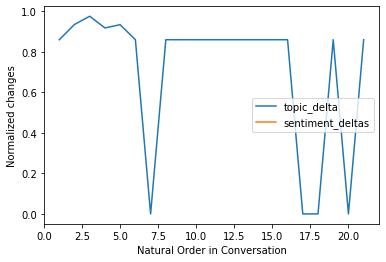

In [8]:
#from sklearn import preprocessing
sv = exampleconversation.sentiment_value
exampleconversation["sentiment_normalized"] = ((sv-sv.min())/(sv.max()-sv.min()))

exampleconversation["sentiment_deltas"] = exampleconversation["sentiment_normalized"].diff().abs()
plot = exampleconversation.plot(y=['topic_delta', "sentiment_deltas"], xlabel = "Natural Order in Conversation", ylabel="Normalized changes", use_index=True)
plot.get_figure().savefig('sentiment_topics.png')

After normalizing, it looks like we can compare the two metrics. However, topic continuation should be
interpreted differently then a continuous sentiment flow.

In order to compute the correlation we need to compute:
- a more precise sentiment classification
- a wider set of conversations with existing topic classifications
- a better metric of the topic flow that takes into account the general frequency of topic  changes and
  can thus highlight conversations with high or low topic volatility